<a href="https://colab.research.google.com/github/omarhatem97/ANER_DEV/blob/main/ANER_dataset_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Arabert Model to do NER Task

### Environment setup

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:

# get the dataset 
!gdown --id  1bYDqmEYKpVmVyGc9Vmz3W_2bsPMel6UC


# The label_lsit file
!gdown --id  1th3j28peQf-asgodeaGo-04aIARN0QoL


# ANER dataset
!gdown --id 10f2KkbvBNDrBAEv_tp1cAR9QmV8CEYv1



############
#
#  Aqmar 
## aqmar test datast
!gdown --id 1-1S27QQYAsFpxXDgs2slPq3D10QvgA20

## aqmar label list
!gdown --id 1Iv-FwkBt0MXsqNG1Sb7HWhslrxCSk1X4

##########




!pip install transformers 
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

Downloading...
From: https://drive.google.com/uc?id=1bYDqmEYKpVmVyGc9Vmz3W_2bsPMel6UC
To: /content/dataset_1.0.txt
6.03MB [00:00, 36.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1th3j28peQf-asgodeaGo-04aIARN0QoL
To: /content/label_list.txt
100% 1.22k/1.22k [00:00<00:00, 1.51MB/s]
Downloading...
From: https://drive.google.com/uc?id=10f2KkbvBNDrBAEv_tp1cAR9QmV8CEYv1
To: /content/ANER_dataset.txt
100% 2.06M/2.06M [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1S27QQYAsFpxXDgs2slPq3D10QvgA20
To: /content/aqmar_test.txt
100% 31.5k/31.5k [00:00<00:00, 77.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Iv-FwkBt0MXsqNG1Sb7HWhslrxCSk1X4
To: /content/aqmar_label_list.txt
100% 95.0/95.0 [00:00<00:00, 475kB/s]
     |████████████████████████████████| 2.6 MB 13.3 MB/s 
     |████████████████████████████████| 895 kB 84.3 MB/s 
     |████████████████████████████████| 636 kB 56.9 MB/s 
     |████████████████████████████████| 3.3 MB 18.4 MB/s 
  At

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from  tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch
from torch import nn

%load_ext google.colab.data_table

## Preprocessing

In this part, we take the dataset, and convert it to list of sentences using the newline token to get the end of each sentence


This function will make a dataset of sentences 

returns: list of shape: 
  [no_sentences] *  [ [words] , [tags] ]

In [ ]:
def read_dataset(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      # line = line.replace(u'\u200e','')
      # line = line.replace(u'\ufeff','')
      if '[NEWLINE]' in line:
        if len(sentence) > 0:
          data.append([sentence,label])
          sentence = []
          label = []
        continue
      line = line.strip('\n')
      splits = line.split(' ')
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append([sentence,label])
  return data

Here we can see after converting the dataset into sentences, that we have 15763 Sentence

In [ ]:

data = read_dataset('ANER_dataset.txt')
print(len(data))


4760


In [ ]:
df = pd.DataFrame(data, columns=['text', 'tags'])
df.head(1)


,text,tags
0,"[فرانكفورت, (, د, ب, ا, ), اعلن, اتحاد, صناعة,...","[B-Population-Center, O, B-Media, I-Media, I-M..."


Here we get the list of all classes we have

In [ ]:
label_list = list(pd.read_csv('label_list.txt', header=None, index_col=0).T)

label_map = { v:index for index, v in enumerate(label_list) }
inv_label_map = {i: label for i, label in enumerate(label_list)}

print(label_map)
print(inv_label_map)

{'O': 0, 'B-Artist': 1, 'I-Artist': 2, 'B-Sound': 3, 'I-Sound': 4, 'B-Educational': 5, 'I-Educational': 6, 'B-Building-Grounds': 7, 'I-Building-Grounds': 8, 'B-Population-Center': 9, 'B-Nation': 10, 'B-State-or-Province': 11, 'I-State-or-Province': 12, 'B-Water-Body': 13, 'I-Water-Body': 14, 'B-Land-Region-Natural': 15, 'I-Land-Region-Natural': 16, 'B-Software': 17, 'I-Software': 18, 'B-Scientist': 19, 'B-Book': 20, 'I-Book': 21, 'I-Scientist': 22, 'B-Group': 23, 'B-Celestial': 24, 'B-Police': 25, 'I-Police': 26, 'I-Population-Center': 27, 'I-Celestial': 28, 'B-Engineer': 29, 'I-Engineer': 30, 'B-Projectile': 31, 'B-Government': 32, 'I-Government': 33, 'B-Commercial': 34, 'I-Commercial': 35, 'B-Continent': 36, 'B-Air': 37, 'I-Air': 38, 'B-Other_PER': 39, 'I-Other_PER': 40, 'I-Group': 41, 'B-Politician': 42, 'I-Politician': 43, 'B-Athlete': 44, 'I-Athlete': 45, 'B-Religious_ORG': 46, 'I-Religious_ORG': 47, 'B-Path': 48, 'I-Path': 49, 'B-Media': 50, 'I-Media': 51, 'B-Non-Governmental': 5

## Dataset splits


We splitthe Dataset into:  90% Train, 10% Valdiation, and 10% Test

In [ ]:
test_data = data

#  train_data, test_data = train_test_split(data,test_size= 0.2)
# # 
#  test_data , eval_data = train_test_split(test_data,test_size= 0.5)

In [ ]:
# print(len(train_data))
print(len(test_data))
# print(len(eval_data))

4760


Here we get the frequency of each class in dataset

In [ ]:
# print(Counter([ label for sentence in train_data for label in sentence[1]]))
print(Counter([ label for sentence in test_data for label in sentence[1]]))



Counter({'O': 149978, 'B-Nation': 2232, 'B-Population-Center': 1427, 'B-Politician': 1315, 'I-Politician': 1206, 'I-Non-Governmental': 871, 'B-Athlete': 865, 'B-Non-Governmental': 767, 'B-Group': 685, 'B-Sports': 661, 'I-Athlete': 621, 'B-Artist': 451, 'B-Other_PER': 444, 'I-Government': 412, 'I-Other_PER': 403, 'I-Artist': 400, 'B-Media': 358, 'I-Building-Grounds': 292, 'B-Government': 284, 'I-Media': 275, 'I-Nation': 265, 'I-Population-Center': 261, 'I-Sports': 259, 'B-Building-Grounds': 238, 'B-State-or-Province': 220, 'B-Religious_PER': 175, 'B-Commercial': 169, 'B-Scientist': 151, 'I-Commercial': 147, 'I-Religious_PER': 145, 'I-Book': 138, 'I-Educational': 126, 'B-GPE-Cluster': 125, 'I-GPE-Cluster': 118, 'I-Movie': 116, 'B-Continent': 109, 'B-Water-Body': 102, 'B-Book': 94, 'I-Water-Body': 76, 'B-Educational': 73, 'B-Movie': 73, 'I-Land': 69, 'B-Land': 68, 'I-Scientist': 62, 'B-Police': 57, 'I-Police': 52, 'I-State-or-Province': 52, 'B-County-or-District': 48, 'B-Businessperson': 

Here we get a histogram of number of tokens in each sentence, to choose  a suitiable size for BERT MAX_LEN

Testing Sentence Lengths: 


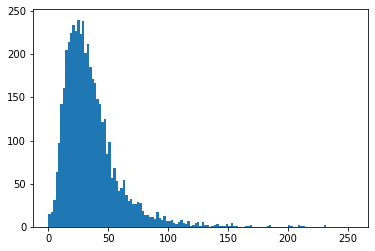

3


In [ ]:
# print("Training Sentence Lengths: ")
# plt.hist([ len(sentence[0]) for sentence in train_data],bins=range(0,256,2))
# plt.show()
# print(sum([len(sentence[0]) > 256 for sentence in train_data]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in test_data],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in test_data]))

## Training


### Model Config

Here, we define some constants to use 

In [ ]:
DATASET_NAME = 'Fine_GRATED'
MODEL_NAME = 'aubmindlab/bert-base-arabertv02'
TASK_NAME = 'tokenclassification'

#######  TODO: Make it 256 again
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
MODEL_PATH = "model"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

### Dataset


Here we define the Dataset class, and how to process batches before training


In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, model_name, max_length):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = ArabertPreprocessor(model_name.split("/")[-1])    
    self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_length = max_length

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = self.tokenizer.tokenize(clean_word)

  
      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = self.tokenizer.num_special_tokens_to_add()
    if len(tokens) > self.max_length - special_tokens_count:
      tokens = tokens[: (self.max_length - special_tokens_count)]
      label_ids = label_ids[: (self.max_length - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [self.tokenizer.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [self.tokenizer.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # ana we ant {pad}
    # 1    1  1   0  0
    # [cls] B-loc O O B-loc [sep] [pad]
    #  -100    2   0  0      -100 

    # Zero-pad up to the sequence length.
    padding_length = self.max_length - len(input_ids)

    input_ids += [self.tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == self.max_length
    assert len(attention_mask) == self.max_length
    assert len(token_type_ids) == self.max_length
    assert len(label_ids) == self.max_length

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }

Here we create The datasets for train,val, and test

In [ ]:


# train_dataset = NERDataset(
#     texts=[x[0] for x in train_data],
#     tags=[x[1] for x in train_data],
#     label_list=label_list,
#     model_name=MODEL_NAME,
#     max_length=MAX_LEN
#     )

test_dataset = NERDataset(
    texts=[x[0] for x in test_data],
    tags=[x[1] for x in test_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

# eval_dataset = NERDataset(
#     texts=[x[0] for x in eval_data],
#     tags=[x[1] for x in eval_data],
#     label_list=label_list,
#     model_name=MODEL_NAME,
#     max_length=MAX_LEN
#     )

### Model init and Data Loaders 

Here we initalize the model as a Brt model for token classification

In [ ]:

def model_init():
    return BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                      return_dict=True,
                                                      num_labels=len(label_map),output_attentions = False,
                                                      output_hidden_states = False)





In [ ]:
my_model = model_init()

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initia

In [ ]:
print(my_model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# train_data_loader = DataLoader(dataset=train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle= True)
# eval_data_loader = DataLoader(dataset=eval_dataset,batch_size=VALID_BATCH_SIZE,shuffle= True)
test_data_loader = DataLoader(dataset=test_dataset,batch_size=TEST_BATCH_SIZE,shuffle= True)

### Train, Eval, Test Functions

#### Helper Funvtions

In [ ]:

def align_predictions(predictions, label_ids):
    """
        Takes batch of senteces, and the logits for every word in every sentences 
        it will exclude the padding tokens 
        
        predictions:  [ [ [logits] ] ]
        label_ids: [[Sentence1], [Sentence2]]
        
        returns : predicition label list of shape (no_sentences, no_words_in_sentece)
                  true label list of shape (no_sentences, no_words_in_sentece)
                  
                  output example: y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
                                  y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
    """
   
    preds = np.argmax(predictions, axis=2)
    
   

    batch_size, seq_len = preds.shape

    assert(preds.shape == label_ids.shape)
    
    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            
            if label_ids[i] [j] != torch.nn.CrossEntropyLoss().ignore_index:
                
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

In [ ]:
def compute_metrics(predictions, labels , generate_report = False):
    
    preds_list, out_label_list = align_predictions(predictions,labels)
    
    
    if generate_report:
        try:         
            print(classification_report(out_label_list, preds_list))
        except:
            print('There Was an error while generating the classification report!')
            
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }


#### Test Function

In [ ]:
def model_test(test_dl,model,device):

    ###########################################
    #                                         #
    #           TEST STARTS HERE              #
    #                                         #
    ###########################################
    with torch.no_grad():
        model.to(device)
        model.eval()
        final_loss = 0
        all_predictions = []
        all_labels = []
        for data in tqdm(test_dl, total = len(test_dl)):

            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            labels = data['labels'].to(device)



            outputs = model(input_ids = input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            
            
            loss = outputs.loss

            predictions = outputs.logits

            all_labels.extend(labels.to('cpu').numpy())
            all_predictions.extend(outputs.logits.to('cpu').numpy())

            final_loss += loss.item()

            #print(np.array(all_predictions).shape)

            # all_labels=  torch.tensor(all_labels).to('cpu').numpy()
            # all_predictions = torch.tensor(all_predictions).to('cpu').numpy()

            
            
        metrics = \
        compute_metrics(predictions=np.asarray(all_predictions), labels=np.asarray(all_labels))

        accuracy_score = metrics['accuracy_score']
        precision= metrics['precision']
        recall= metrics['recall']
        f1= metrics['f1']

        print(f' Accuracy: {accuracy_score}')
        print(f' Precision: {precision}')
        print(f' Recall: {recall}')
        print(f' F1: {f1}')


        final_loss /= len(test_dl) 

        print(f'Final Test Loss is: {final_loss}' )


### Testing

In [ ]:
! cp drive/MyDrive/Models/full_model_v2 .

In [ ]:
############ TESTING ###########


# test_model = model_init()
# test_model.load_state_dict(torch.load('model_v1', map_location='cpu'))

test_model = torch.load('full_model_v2' ,map_location='cpu')

model_test(test_dl= test_data_loader,model=test_model, device= device)


 Accuracy: 0.9677850108496078
 Precision: 0.7739946147832885
 Recall: 0.7814610190300798
 F1: 0.777709897015186
Final Test Loss is: 0.22581731898072582
